In [4]:
import os
import cv2
import numpy as np

import open3d as o3d
from scipy.interpolate import RectBivariateSpline
from sklearn.neighbors import NearestNeighbors
import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def MatchSIFT(loc1, des1, loc2, des2):
    """
    Find the matches of SIFT features between two images
    
    Parameters
    ----------
    loc1 : ndarray of shape (n1, 2)
        Keypoint locations in image 1
    des1 : ndarray of shape (n1, 128)
        SIFT descriptors of the keypoints image 1
    loc2 : ndarray of shape (n2, 2)
        Keypoint locations in image 2
    des2 : ndarray of shape (n2, 128)
        SIFT descriptors of the keypoints image 2

    Returns
    -------
    x1 : ndarray of shape (m, 2)
        The matched keypoint locations in image 1
    x2 : ndarray of shape (m, 2)
        The matched keypoint locations in image 2
    ind1 : ndarray of shape (m,)
        The indices of x1 in loc1
    """

    filter = NearestNeighbors(n_neighbors=2)
    samples = des1
    filter.fit(samples)
    match_dist = []
    match_index1 = []
    match_index2 = []
    for i in range(des2.shape[0]):
        dist, index = filter.kneighbors([des2[i]])
        if dist[0][0] < dist[0][1] * 0.8:
            match_dist.append(dist[0][0])
            match_index1.append(index[0][0])
            match_index2.append(i)
    match_dist = np.asarray(match_dist)
    match_index1 = np.asarray(match_index1)
    match_index2 = np.asarray(match_index2)

    filter2 = NearestNeighbors(n_neighbors=2)
    filter2.fit(des2)
    delete = []
    for i in range(match_index1.size):
        dist, index = filter2.kneighbors([des1[match_index1[i]]])
        if dist[0][0] > 0.8 * dist[0][1]:
            delete.append(i)

    match_index1 = np.delete(match_index1, delete)
    match_index2 = np.delete(match_index2, delete)
    match_dist = np.delete(match_dist, delete)

    x1 = []
    x2 = []
    for query, train in zip(match_index1, match_index2):
        x1.append([loc1[query].pt[0], loc1[query].pt[1]])
        x2.append([loc2[train].pt[0], loc2[train].pt[1]])
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)

    return x1, x2, match_index1

In [6]:
def EstimateE(x1, x2):
    """
    Estimate the essential matrix, which is a rank 2 matrix with singular values
    (1, 1, 0)

    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Set of correspondences in the first image
    x2 : ndarray of shape (n, 2)
        Set of correspondences in the second image

    Returns
    -------
    E : ndarray of shape (3, 3)
        The essential matrix
    """
    
    n = x1.shape[0]
    A = np.zeros((n, 9))

    for i in range(n):
        u1, v1 = x1[i]
        u2, v2 = x2[i]
        A[i] = [u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1]

    _, _, V = np.linalg.svd(A)
    E = V[-1].reshape(3, 3)

    U, S, V = np.linalg.svd(E)
    S = np.array([1,1,0])
    E = U @ np.diag(S) @ V

    return E


In [7]:
def EstimateE_RANSAC(x1, x2, ransac_n_iter, ransac_thr):
    """
    Estimate the essential matrix robustly using RANSAC

    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Set of correspondences in the first image
    x2 : ndarray of shape (n, 2)
        Set of correspondences in the second image
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    E : ndarray of shape (3, 3)
        The essential matrix
    inlier : ndarray of shape (k,)
        The inlier indices
    """
    
    max_inliers = 0
    best_E = None
    best_inlier = None

    for i in range(ransac_n_iter):
        random_idx = random.sample(range(x1.shape[0]), 8)
        u = x1[random_idx]
        v = x2[random_idx]
        E = EstimateE(u, v)

        x1_h = np.hstack((x1, np.ones((x1.shape[0], 1))))
        x2_h = np.hstack((x2, np.ones((x2.shape[0], 1))))

        inlier_idx = []
        for j in range(x1.shape[0]):
            line = E @ x1_h[j]
            if np.absolute(np.dot(x2_h[j], line) / np.sqrt(line[0]**2 + line[1]**2)) < ransac_thr:
                inlier_idx.append(j)
        
        # print(len(inlier_idx))

        if len(inlier_idx) > max_inliers:
            max_inliers = len(inlier_idx)
            best_E = E
            best_inlier = inlier_idx

    return best_E, best_inlier

In [8]:
# Visualization of Epipolar lines & checking the essential matrix

K = np.asarray([
        [463.1, 0, 333.2],
        [0, 463.1, 187.5],
        [0, 0, 1]
    ])
img = cv2.imread('./images/image1.jpg')
im1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('./images/image2.jpg')
im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
loc1, des1 = sift.detectAndCompute(im1, None)
loc2, des2 = sift.detectAndCompute(im2, None)

x1_bfn, x2_bfn, _ = MatchSIFT(loc1, des1, loc2, des2)

In [9]:
# Homogeneous cood of bfn points
x1_bfn_h = np.hstack((x1_bfn, np.ones((x1_bfn.shape[0], 1))))
x2_bfn_h = np.hstack((x2_bfn, np.ones((x2_bfn.shape[0], 1))))

# Homogeneous cood of after normalization points
x1_n_h = np.dot(x1_bfn_h, np.linalg.inv(K).T)
x2_n_h = np.dot(x2_bfn_h, np.linalg.inv(K).T)

# Normalized cood
x1_n = x1_n_h[:, :2] / x1_n_h[:, 2, np.newaxis]
x2_n = x2_n_h[:, :2] / x2_n_h[:, 2, np.newaxis]

E, inlier = EstimateE_RANSAC(x1_n, x2_n, 200, 0.01)

In [10]:
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(map(int, pt1)),5,color,-1)
        img2 = cv2.circle(img2,tuple(map(int, pt2)),5,color,-1)
    return img1,img2

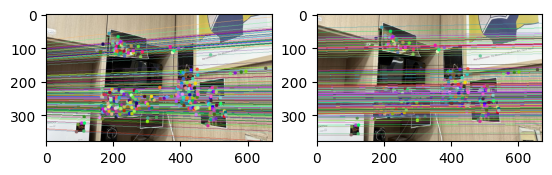

In [11]:
# OpenCV lib use
# F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
 
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
 
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(loc2[m.trainIdx].pt)
        pts1.append(loc1[m.queryIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
 
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image

pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
pts2_h = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

# lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = pts2_h @ F
lines1 = lines1.reshape(-1,3)
lines2 = pts1_h @ F.T
lines2 = lines2.reshape(-1, 3)
img5,img6 = drawlines(im1,im2,lines1,pts1,pts2)

img3,img4 = drawlines(im2,im1,lines2,pts2,pts1)
 
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [12]:
F

array([[ 1.13025037e-07, -1.30037565e-06,  5.08341178e-04],
       [ 1.19364666e-05,  1.23829981e-06,  1.93661653e-02],
       [-2.93641987e-03, -2.35783672e-02,  1.00000000e+00]])

In [ ]:
def BuildFeatureTrack(Im, K):
    """
    Build feature track

    Parameters
    ----------
    Im : ndarray of shape (N, H, W, 3)
        Set of N images with height H and width W
    K : ndarray of shape (3, 3)
        Intrinsic parameters

    Returns
    -------
    track : ndarray of shape (N, F, 2)
        The feature tensor, where F is the number of total features
    """
    
    n = Im.shape[0]
    Loc = []
    Des = []
    sift = cv2.SIFT_create()
    track = []

    for i in range(n):
        loc, des = sift.detectAndCompute(Im[i], None)
        Loc.append(loc)
        Des.append(des)
    
    for i in range(n):
        print(i)
        track_i = np.full((n, len(Loc[i]), 2), -1, np.float32)
        for j in range(i+1, n):
            x1, x2, idx1 = MatchSIFT(Loc[i], Des[i], Loc[j], Des[j])
            x1_h = np.hstack((x1, np.ones((x1.shape[0], 1))))
            x2_h = np.hstack((x2, np.ones((x2.shape[0], 1))))
            
            # Homogeneous cood for normalized coordinates
            x1_n_h = x1_h @ np.linalg.inv(K).T
            x2_n_h = x2_h @ np.linalg.inv(K).T
            # 2D cood for normalized coordinates
            x1_n = x1_n_h[:, :2]
            x2_n = x2_n_h[:, :2]

            _, inliers = EstimateE_RANSAC(x1_n, x2_n, 200, 0.01)

            for inlier in inliers:
                track_i[i][idx1[inlier]] = x1_n[inlier]
                track_i[j][idx1[inlier]] = x2_n[inlier]

        valid_features = np.any(track_i != np.array(-1), axis=(0, 2))
        print(f"track_i size = {np.shape(track_i)}, valid_features size = {np.shape(np.where(valid_features))}")
        track_i = track_i[:, valid_features]
        print(f"new track_i size: {np.shape(track_i)}")
        track.append(track_i)

    track = np.concatenate(track, axis=1)

    return track

In [ ]:
# Load input images
# test is 5
num_images = 14
w_im = 672
h_im = 378
Im = np.empty((num_images, h_im, w_im, 3), dtype=np.uint8)
for i in range(num_images):
    im_file = 'images/image{:d}.jpg'.format(i + 1)
    im = cv2.imread(im_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    Im[i,:,:,:] = im

# Build feature track
track = BuildFeatureTrack(Im, K)

print(np.shape(track))

0
track_i size = (14, 672, 2), valid_features size = (1, 525)
new track_i size: (14, 525, 2)
1
track_i size = (14, 670, 2), valid_features size = (1, 530)
new track_i size: (14, 530, 2)
2
track_i size = (14, 725, 2), valid_features size = (1, 601)
new track_i size: (14, 601, 2)
3


KeyboardInterrupt: 

In [ ]:
print(track[:, 100])

[[-0.26608792  0.13034943]
 [-0.2588916   0.12168659]
 [-1.         -1.        ]
 [-0.32563758  0.15318605]
 [-0.32468376  0.1469001 ]]


In [ ]:
def GetCameraPoseFromE(E):
    """
    Find four conﬁgurations of rotation and camera center from E

    Parameters
    ----------
    E : ndarray of shape (3, 3)
        Essential matrix

    Returns
    -------
    R_set : ndarray of shape (4, 3, 3)
        The set of four rotation matrices
    C_set : ndarray of shape (4, 3)
        The set of four camera centers
    """
    
    U, _, V = np.linalg.svd(E)
    u_3 = U[:,-1]
    
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R_1 = U @ W @ V
    R_2 = U @ W.T @ V

    R_1 = R_1 if np.linalg.det(R_1) > 0 else -R_1
    R_2 = R_2 if np.linalg.det(R_2) > 0 else -R_2

    R_set = np.array([R_1, R_1, R_2, R_2])
    C_set = np.array([-R_1.T @ u_3, R_1.T @ u_3, -R_2.T @ u_3, R_2.T @ u_3])

    return R_set, C_set

In [ ]:
def Triangulation(P1, P2, track1, track2):
    """
    Use the linear triangulation method to triangulation the point

    Parameters
    ----------
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    track1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    track2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    X : ndarray of shape (n, 3)
        The set of 3D points
    """
    X = []
    
    n = len(track1)
    for i in range(n):
        if track1[i, 0] == -1 or track2[i, 0] == -1:
            X.append(np.array([-1, -1, -1]))
        else:
            x1, y1 = track1[i]
            x2, y2 = track2[i]
            A = np.array([x1 * P1[2] - P1[0], y1 * P1[2] - P1[1], x2 * P2[2] - P2[0], y2 * P2[2] - P2[1]])
            _, _, V = np.linalg.svd(A)
            v3 = V[-1]
            X.append(np.array([v3[0]/v3[3], v3[1]/v3[3], v3[2]/v3[3]]))

    X = np.asarray(X)

    return X


In [ ]:
def EvaluateCheirality(P1, P2, X):
    """
    Evaluate the cheirality condition for the 3D points

    Parameters
    ----------
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    X : ndarray of shape (n, 3)
        Set of 3D points

    Returns
    -------
    valid_index : ndarray of shape (n,)
        The binary vector indicating the cheirality condition, i.e., the entry 
        is 1 if the point is in front of both cameras, and 0 otherwise
    """
    n = X.shape[0]
    valid_index = np.zeros(n)    

    for i in range(n):
        X1_cam = np.dot(P1[:, 0:3], X[i]) + P1[:, 3]
        X2_cam = np.dot(P2[:, 0:3], X[i]) + P2[:, 3]

        if X1_cam[2] > 0 and X2_cam[2] > 0:
            valid_index[i] = 1

    return valid_index

In [ ]:
def EstimateCameraPose(track1, track2):
    """
    Return the best pose conﬁguration

    Parameters
    ----------
    track1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    track2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    X : ndarray of shape (F, 3)
        The set of reconstructed 3D points
    """
    
    valid = np.logical_and(np.all(track1 != -1, axis=1), np.all(track2 != -1, axis=1))
    x1 = track1[np.where(valid)]
    x2 = track2[np.where(valid)]
    print(x1.shape, x2.shape)

    # Use already normalized cood from track
    E, _ = EstimateE_RANSAC(x1, x2, 200, 0.01)

    R_set, C_set = GetCameraPoseFromE(E)
    P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

    max_cnt = 0
    max_i = 0

    for i in range(4):
        P2 = np.concatenate((R_set[i], np.expand_dims(-R_set[i]@C_set[i], axis=1)), axis=1)
        X = Triangulation(P1, P2, track1, track2)
        chr = EvaluateCheirality(P1, P2, X)
        cnt = np.count_nonzero(chr)
        # print(cnt)
        if cnt > max_cnt:
            max_cnt = cnt
            max_i = i   
            max_X = X

    R = R_set[max_i]
    C = C_set[max_i]
    X = max_X

    return R, C, X

In [ ]:
track1 = track[0,:,:]
track2 = track[1,:,:]

# Estimate ﬁrst two camera poses
R, C, X = EstimateCameraPose(track1, track2)

(325, 2) (325, 2)


In [ ]:
print(X.shape)

(1599, 3)


In [ ]:
def Rotation2Quaternion(R):
    """
    Convert a rotation matrix to quaternion
    
    Parameters
    ----------
    R : ndarray of shape (3, 3)
        Rotation matrix

    Returns
    -------
    q : ndarray of shape (4,)
        The unit quaternion (w, x, y, z)
    """
    q = np.empty([4,])

    tr = np.trace(R)
    if tr < 0:
        i = R.diagonal().argmax()
        j = (i + 1) % 3
        k = (j + 1) % 3

        q[i] = np.sqrt(1 - tr + 2 * R[i, i]) / 2
        q[j] = (R[j, i] + R[i, j]) / (4 * q[i])
        q[k] = (R[k, i] + R[i, k]) / (4 * q[i])
        q[3] = (R[k, j] - R[j, k]) / (4 * q[i])
    else:
        q[3] = np.sqrt(1 + tr) / 2
        q[0] = (R[2, 1] - R[1, 2]) / (4 * q[3])
        q[1] = (R[0, 2] - R[2, 0]) / (4 * q[3])
        q[2] = (R[1, 0] - R[0, 1]) / (4 * q[3])

    q /= np.linalg.norm(q)
    # Rearrange (x, y, z, w) to (w, x, y, z)
    q = q[[3, 0, 1, 2]]

    return q



def Quaternion2Rotation(q):
    """
    Convert a quaternion to rotation matrix
    
    Parameters
    ----------
    q : ndarray of shape (4,)
        Unit quaternion (w, x, y, z)

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    """
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]

    R = np.empty([3, 3])
    R[0, 0] = 1 - 2 * y**2 - 2 * z**2
    R[0, 1] = 2 * (x*y - z*w)
    R[0, 2] = 2 * (x*z + y*w)

    R[1, 0] = 2 * (x*y + z*w)
    R[1, 1] = 1 - 2 * x**2 - 2 * z**2
    R[1, 2] = 2 * (y*z - x*w)

    R[2, 0] = 2 * (x*z - y*w)
    R[2, 1] = 2 * (y*z + x*w)
    R[2, 2] = 1 - 2 * x**2 - 2 * y**2

    return R

In [ ]:
def ComputePoseJacobian(p, X):
    """
    Compute the pose Jacobian

    Parameters
    ----------
    p : ndarray of shape (7,)
        Camera pose made of camera center and quaternion
    X : ndarray of shape (3,)
        3D point

    Returns
    -------
    dfdp : ndarray of shape (2, 7)
        The pose Jacobian
    """
    C = p[:3]
    q = p[3:]
    R = Quaternion2Rotation(q)
    x = R @ (X - C)

    u = x[0]
    v = x[1]
    w = x[2]
    du_dc = -R[0,:]
    dv_dc = -R[1,:]
    dw_dc = -R[2,:]
    # df_dc is in shape (2, 3)
    df_dc = np.stack([
        (w * du_dc - u * dw_dc) / (w**2),
        (w * dv_dc - v * dw_dc) / (w**2)
    ], axis=0)

    # du_dR = np.concatenate([X-C, np.zeros(3), X-C])
    # dv_dR = np.concatenate([np.zeros(3), X-C, X-C])
    # dw_dR = np.concatenate([np.zeros(3), np.zeros(3), X-C])
    du_dR = np.concatenate([X-C, np.zeros(3), np.zeros(3)])
    dv_dR = np.concatenate([np.zeros(3), X-C, np.zeros(3)])
    dw_dR = np.concatenate([np.zeros(3), np.zeros(3), X-C])
    # df_dR is in shape (2, 9)
    df_dR = np.stack([
        (w * du_dR - u * dw_dR) / (w**2),
        (w * dv_dR - v * dw_dR) / (w**2)
    ], axis=0)


    qw = q[0]
    qx = q[1]
    qy = q[2]
    qz = q[3]
    # dR_dq is in shape (9, 4)
    dR_dq = np.asarray([
        [0, 0, -4*qy, -4*qz],
        [-2*qz, 2*qy, 2*qx, -2*qw],
        [2*qy, 2*qz, 2*qw, 2*qx],
        [2*qz, 2*qy, 2*qx, 2*qw],
        [0, -4*qx, 0, -4*qz],
        [-2*qx, -2*qw, 2*qz, 2*qy],
        [-2*qy, 2*qz, -2*qw, 2*qx],
        [2*qx, 2*qw, 2*qz, 2*qy],
        [0, -4*qx, -4*qy, 0],
    ])

    dfdp = np.hstack([df_dc, df_dR @ dR_dq])

    return dfdp


def PnP_nl(R, C, X, x):
    """
    Update the pose using the pose Jacobian

    Parameters
    ----------
    R : ndarray of shape (3, 3)
        Rotation matrix refined by PnP
    c : ndarray of shape (3,)
        Camera center refined by PnP
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image

    Returns
    -------
    R_refined : ndarray of shape (3, 3)
        The rotation matrix refined by nonlinear optimization
    C_refined : ndarray of shape (3,)
        The camera center refined by nonlinear optimization
    """
    n = X.shape[0]
    q = Rotation2Quaternion(R)

    p = np.concatenate([C, q])
    n_iters = 20
    lamb = 1
    error = np.empty((n_iters,))
    for i in range(n_iters):
        R_i = Quaternion2Rotation(p[3:])
        C_i = p[:3]

        proj = (X - C_i[np.newaxis,:]) @ R_i.T
        proj = proj[:,:2] / proj[:,2,np.newaxis]

        H = np.zeros((7,7))
        J = np.zeros(7)
        for j in range(n):
            dfdp = ComputePoseJacobian(p, X[j,:])
            H = H + dfdp.T @ dfdp
            J = J + dfdp.T @ (x[j,:] - proj[j,:])
        
        delta_p = np.linalg.inv(H + lamb*np.eye(7)) @ J
        p += delta_p
        p[3:] /= np.linalg.norm(p[3:])

        error[i] = np.linalg.norm(proj - x)


    R_refined = Quaternion2Rotation(p[3:])
    C_refined = p[:3]
    return R_refined, C_refined

In [ ]:
def PnP(X, x):
    """
    Implement the linear perspective-n-point algorithm

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    """
    
    n = x.shape[0]
    A = np.zeros((2*n, 12))

    for i in range(n):
        I, J, K = X[i]
        i, j = x[i]
        A[2*i] = [I, J, K, 1, 0, 0, 0, 0, -i*I, -i*J, -i*K, -i]
        A[2*i+1] = [0, 0, 0, 0, I, J, K, 1, -j*I, -j*J, -j*K, -j]

    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape(3, 4)
    R = P[:, 0:3]
    U, _, V = np.linalg.svd(R)
    R = U @ V
    
    C = -R.T @ P[:, 3]

    return R, C

In [ ]:
def PnP_RANSAC(X, x, ransac_n_iter, ransac_thr):
    """
    Estimate pose using PnP with RANSAC

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    inlier : ndarray of shape (n,)
        The indicator of inliers, i.e., the entry is 1 if the point is a inlier,
        and 0 otherwise
    """
    
    n = x.shape[0]
    max_inliers = 0
    best_inlier = None
    max_R = None
    max_C = None

    for i in range(ransac_n_iter):
        random_idx = random.sample(range(n), 4)
        U = X[random_idx]
        u = x[random_idx]
        R_est, C_est = PnP(U, u) #Estimated R, C from P4P algorithm

        P = np.concatenate((R_est, np.expand_dims(-R_est@C_est, axis=1)), axis=1)
        X_h = np.hstack((X, np.ones((n, 1))))
        cnt_inliers = 0
        inlier = np.zeros(n)

        # Count inliers according to reprojection error
        for j in range(n):
            y_h = np.dot(P, X_h[j])
            y = [y_h[0]/y_h[2], y_h[1]/y_h[2]]
            if np.linalg.norm(x[j] - y) < ransac_thr:
                cnt_inliers += 1
                inlier[j] = 1
        
        if cnt_inliers > max_inliers:
            max_inliers = cnt_inliers
            best_inlier = inlier
            max_R = R_est
            max_C = C_est

    inlier = best_inlier
    R = max_R
    C = max_C

    return R, C, inlier

In [ ]:
from scipy.optimize import least_squares


def FindMissingReconstruction(X, track_i):
    """
    Find the points that will be newly added

    Parameters
    ----------
    X : ndarray of shape (F, 3)
        3D points
    track_i : ndarray of shape (F, 2)
        2D points of the newly registered image

    Returns
    -------
    new_point : ndarray of shape (F,)
        The indicator of new points that are valid for the new image and are 
        not reconstructed yet
    """
    
    # TODO Your code goes here

    return new_point



def Triangulation_nl(X, P1, P2, x1, x2):
    """
    Refine the triangulated points

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        3D points
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    x1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    x2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    X_new : ndarray of shape (n, 3)
        The set of refined 3D points
    """
    R1 = P1[:,:3]
    C1 = -R1.T @ P1[:,3]
    R2 = P2[:,:3]
    C2 = -R2.T @ P2[:,3]

    p1 = np.concatenate([C1, Rotation2Quaternion(R1)])
    p2 = np.concatenate([C2, Rotation2Quaternion(R2)])

    lamb = 0.005
    n_iter = 10
    X_new = X.copy()
    for i in range(X.shape[0]):
        pt = X[i,:]
        for j in range(n_iter):
            proj1 = R1 @ (pt - C1)
            proj1 = proj1[:2] / proj1[2]
            proj2 = R2 @ (pt - C2)
            proj2 = proj2[:2] / proj2[2]

            dfdX1 = ComputePointJacobian(pt, p1)
            dfdX2 = ComputePointJacobian(pt, p2)

            H1 = dfdX1.T @ dfdX1 + lamb * np.eye(3)
            H2 = dfdX2.T @ dfdX2 + lamb * np.eye(3)

            J1 = dfdX1.T @ (x1[i,:] - proj1)
            J2 = dfdX2.T @ (x2[i,:] - proj2)

            delta_pt = np.linalg.inv(H1) @ J1 + np.linalg.inv(H2) @ J2
            pt += delta_pt

        X_new[i,:] = pt

    return X_new


def ComputePointJacobian(X, p):
    """
    Compute the point Jacobian

    Parameters
    ----------
    X : ndarray of shape (3,)
        3D point
    p : ndarray of shape (7,)
        Camera pose made of camera center and quaternion

    Returns
    -------
    dfdX : ndarray of shape (2, 3)
        The point Jacobian
    """
    R = Quaternion2Rotation(p[3:])
    C = p[:3]
    x = R @ (X - C)

    u = x[0]
    v = x[1]
    w = x[2]
    du_dc = R[0, :]
    dv_dc = R[1, :]
    dw_dc = R[2, :]

    dfdX = np.stack([
        (w * du_dc - u * dw_dc) / (w**2),
        (w * dv_dc - v * dw_dc) / (w**2)
    ], axis=0)

    return dfdX

In [ ]:

def FindMissingReconstruction(X, track_i):
    """
    Find the points that will be newly added

    Parameters
    ----------
    X : ndarray of shape (F, 3)
        3D points
    track_i : ndarray of shape (F, 2)
        2D points of the newly registered image

    Returns
    -------
    new_point : ndarray of shape (F,)
        The indicator of new points that are valid for the new image and are 
        not reconstructed yet
    """
    
    F = X.shape[0]
    new_point = np.zeros((F, 1))
    
    for i in range(F):
        if np.all(X[i] == -1) and np.all(track_i[i] != -1):
            new_point[i] == 1

    return new_point